In [1]:
import torch
import pickle
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from training.ffn import GestureNet
import pandas as pd


In [2]:
# Check for available devices
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal Performance Shaders (Apple GPU)
    print("Using device: MPS (Metal Performance Shaders)")
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU if available
    print("Using device: CUDA")
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("Using device: CPU")

Using device: MPS (Metal Performance Shaders)


In [3]:
# load model
model_path = "checkpoints/pickles/model_gesture_recog_1.pkl"
with open(model_path, "rb") as f:
    model = pickle.load(f)
    
model.eval()
model.to(device)

GestureNet(
  (network_stack): Sequential(
    (0): Linear(in_features=63, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=7, bias=True)
  )
)

In [4]:
train_file_path = "data/train_gesture_data.csv"
eval_file_path = "data/eval_gesture_data.csv"
val_file_path = "data/val_gesture_data.csv"


def load_data(file_path):
    df = pd.read_csv(file_path, index_col=False)
    y = df['label']
    X = df.drop(columns=['label'])
    
    return X, y

# Load training, evaluation, and validation data
X_eval, y_eval = load_data(eval_file_path)
X_val, y_val = load_data(val_file_path)
X_train, y_train  = load_data(train_file_path)

# combine both to get unified testing data
X_test = pd.concat([X_eval, X_val], axis=0)     # concat features
y_test = pd.concat([y_eval, y_val], axis=0)     # concat labels

print(f"combined test data shape: {X_test.shape}")
print(f"combined test labels shape: {y_test.shape}")

X_test.describe()




combined test data shape: (1387, 63)
combined test labels shape: (1387,)


,0_x,0_y,0_z,1_x,1_y,1_z,2_x,2_y,2_z,3_x,...,17_z,18_x,18_y,18_z,19_x,19_y,19_z,20_x,20_y,20_z
count,1387.000000,1387.000000,1.387000e+03,1387.000000,1387.000000,1387.000000,1387.000000,1387.000000,1387.000000,1387.000000,...,1387.000000,1387.000000,1387.000000,1387.000000,1387.000000,1387.000000,1387.000000,1387.000000,1387.000000,1387.000000
mean,0.582281,0.746242,1.720768e-07,0.545568,0.712471,-0.018856,0.521092,0.649991,-0.029009,0.512713,...,-0.023997,0.605372,0.530559,-0.042113,0.601167,0.536484,-0.044833,0.597480,0.541979,-0.043367
std,0.206585,0.204726,3.172753e-07,0.217415,0.202245,0.016496,0.232176,0.201972,0.024585,0.247972,...,0.027139,0.259592,0.210720,0.034104,0.261917,0.221053,0.033034,0.260225,0.232015,0.032656
min,0.113612,0.240401,-7.650000e-07,0.036574,0.208540,-0.091857,-0.031780,0.147234,-0.149242,-0.078117,...,-0.148543,0.033431,0.072312,-0.201251,0.000016,0.083839,-0.237794,-0.028279,0.037212,-0.267868
25%,0.404382,0.614083,-7.735000e-08,0.357269,0.574967,-0.026194,0.310427,0.505338,-0.040344,0.291936,...,-0.038850,0.372672,0.368537,-0.062163,0.365131,0.366511,-0.064352,0.362354,0.359767,-0.060840
50%,0.623254,0.769263,2.364649e-07,0.591069,0.733214,-0.016923,0.569936,0.667380,-0.024811,0.554919,...,-0.022961,0.657155,0.534992,-0.038840,0.654174,0.544004,-0.042810,0.650423,0.552448,-0.043846
75%,0.759366,0.904428,3.977069e-07,0.731755,0.859434,-0.009934,0.721898,0.793327,-0.015116,0.726220,...,-0.008348,0.841016,0.678013,-0.020847,0.834554,0.685612,-0.025946,0.833186,0.702566,-0.025876
max,0.944499,1.273260,1.008835e-06,0.930340,1.214625,0.066195,0.924379,1.141228,0.099622,0.966263,...,0.058866,1.030548,1.085119,0.073812,1.043863,1.123987,0.076234,1.056661,1.164919,0.076223


In [5]:
X_train.describe()

,0_x,0_y,0_z,1_x,1_y,1_z,2_x,2_y,2_z,3_x,...,17_z,18_x,18_y,18_z,19_x,19_y,19_z,20_x,20_y,20_z
count,3234.000000,3234.000000,3.234000e+03,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,...,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000
mean,0.568678,0.751021,1.748860e-07,0.530638,0.718732,-0.018772,0.505064,0.656073,-0.029143,0.496732,...,-0.025444,0.589315,0.531148,-0.043841,0.584137,0.537965,-0.046502,0.580016,0.544613,-0.044947
std,0.212458,0.205717,3.217004e-07,0.223295,0.203338,0.016469,0.238268,0.202225,0.024660,0.254940,...,0.026144,0.264355,0.212026,0.032848,0.266916,0.222634,0.031370,0.265278,0.233403,0.030588
min,0.108650,0.239104,-8.340000e-07,0.038115,0.219018,-0.103124,-0.028035,0.154324,-0.163064,-0.084128,...,-0.145435,0.031199,0.073496,-0.193642,0.003024,0.083440,-0.175617,-0.022591,0.023301,-0.190563
25%,0.374997,0.601639,-7.500000e-08,0.323513,0.565207,-0.027172,0.280850,0.495443,-0.042416,0.256778,...,-0.039971,0.336644,0.360183,-0.064449,0.330183,0.358961,-0.066644,0.330344,0.350680,-0.062675
50%,0.610121,0.773110,2.387799e-07,0.573194,0.738698,-0.017120,0.545034,0.669053,-0.025786,0.536187,...,-0.024405,0.636399,0.529159,-0.041700,0.632881,0.541964,-0.045540,0.625822,0.545278,-0.046082
75%,0.751316,0.908487,4.049453e-07,0.721703,0.874470,-0.010004,0.710481,0.813725,-0.015219,0.721258,...,-0.009999,0.825665,0.687687,-0.023066,0.825403,0.702488,-0.027575,0.820479,0.719835,-0.027378
max,0.964556,1.232349,1.041217e-06,0.928576,1.183110,0.069232,0.922761,1.147514,0.086152,0.970640,...,0.059901,1.031686,1.114193,0.076234,1.050794,1.133024,0.080847,1.066074,1.157580,0.082703


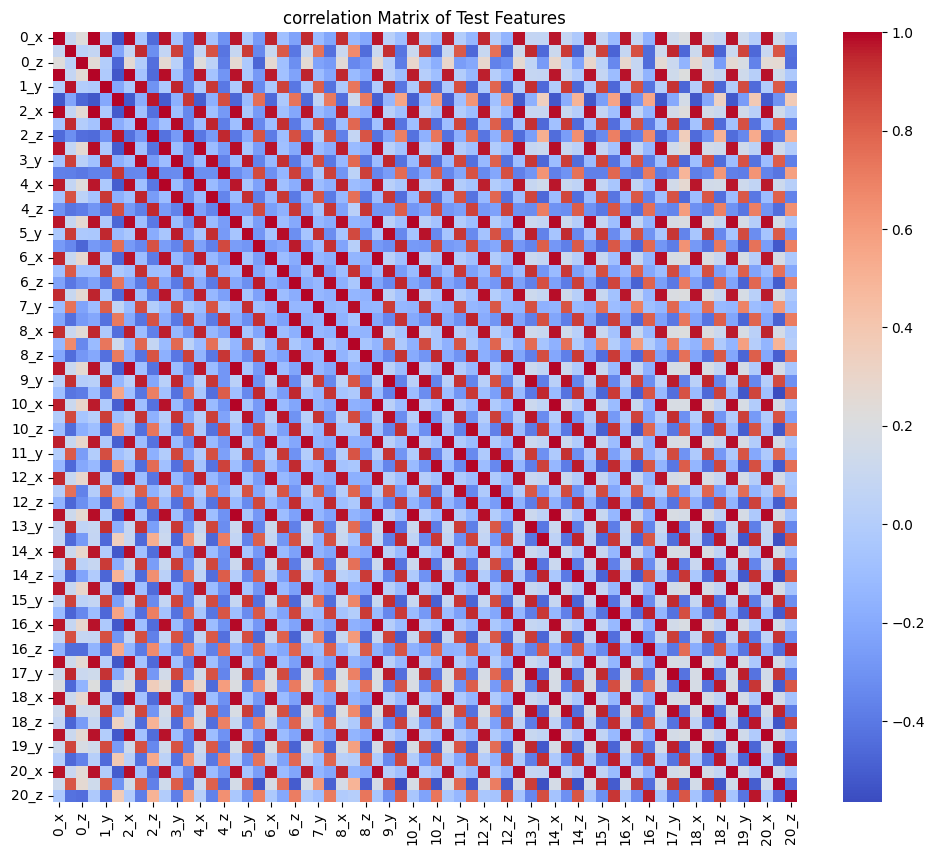

In [6]:
corr_train = X_test.corr()

# plotting correlation matrix of testing data
plt.figure(figsize=(12, 10))
sns.heatmap(corr_train, annot=False, cmap='coolwarm', fmt='.2f')
plt.title("correlation Matrix of Test Features")
plt.show()

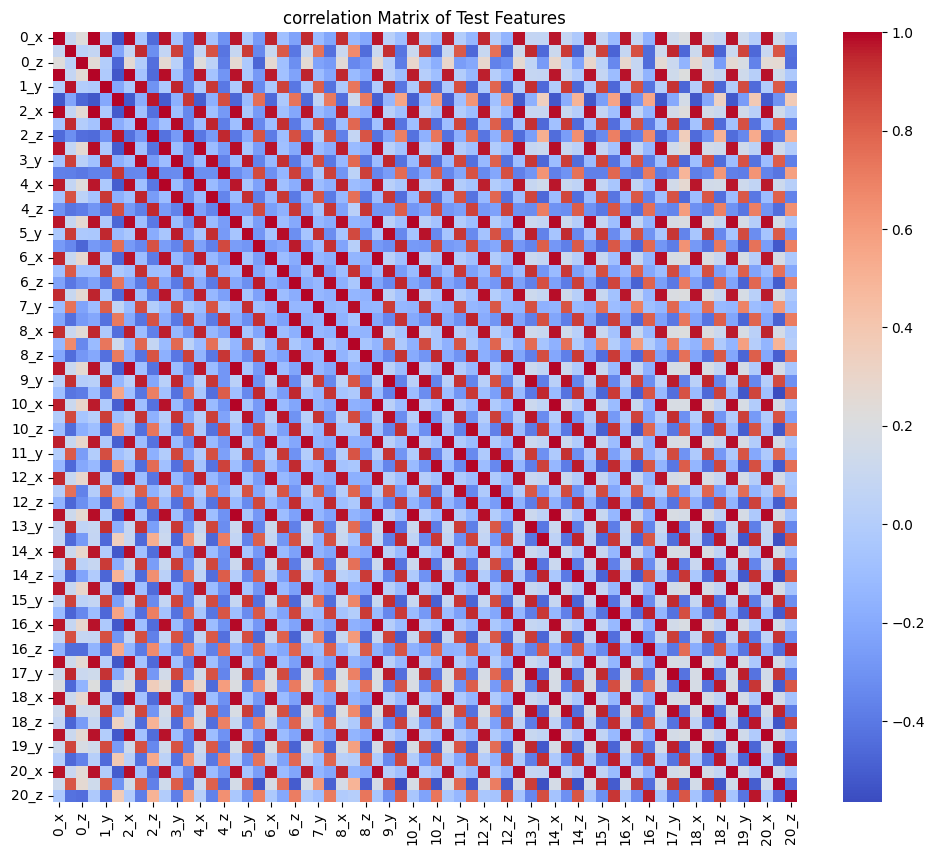

In [7]:

corr_test = X_test.corr()

# plotting correlation matrix of testing data
plt.figure(figsize=(12, 10))
sns.heatmap(corr_test, annot=False, cmap='coolwarm', fmt='.2f')
plt.title("correlation Matrix of Test Features")
plt.show()

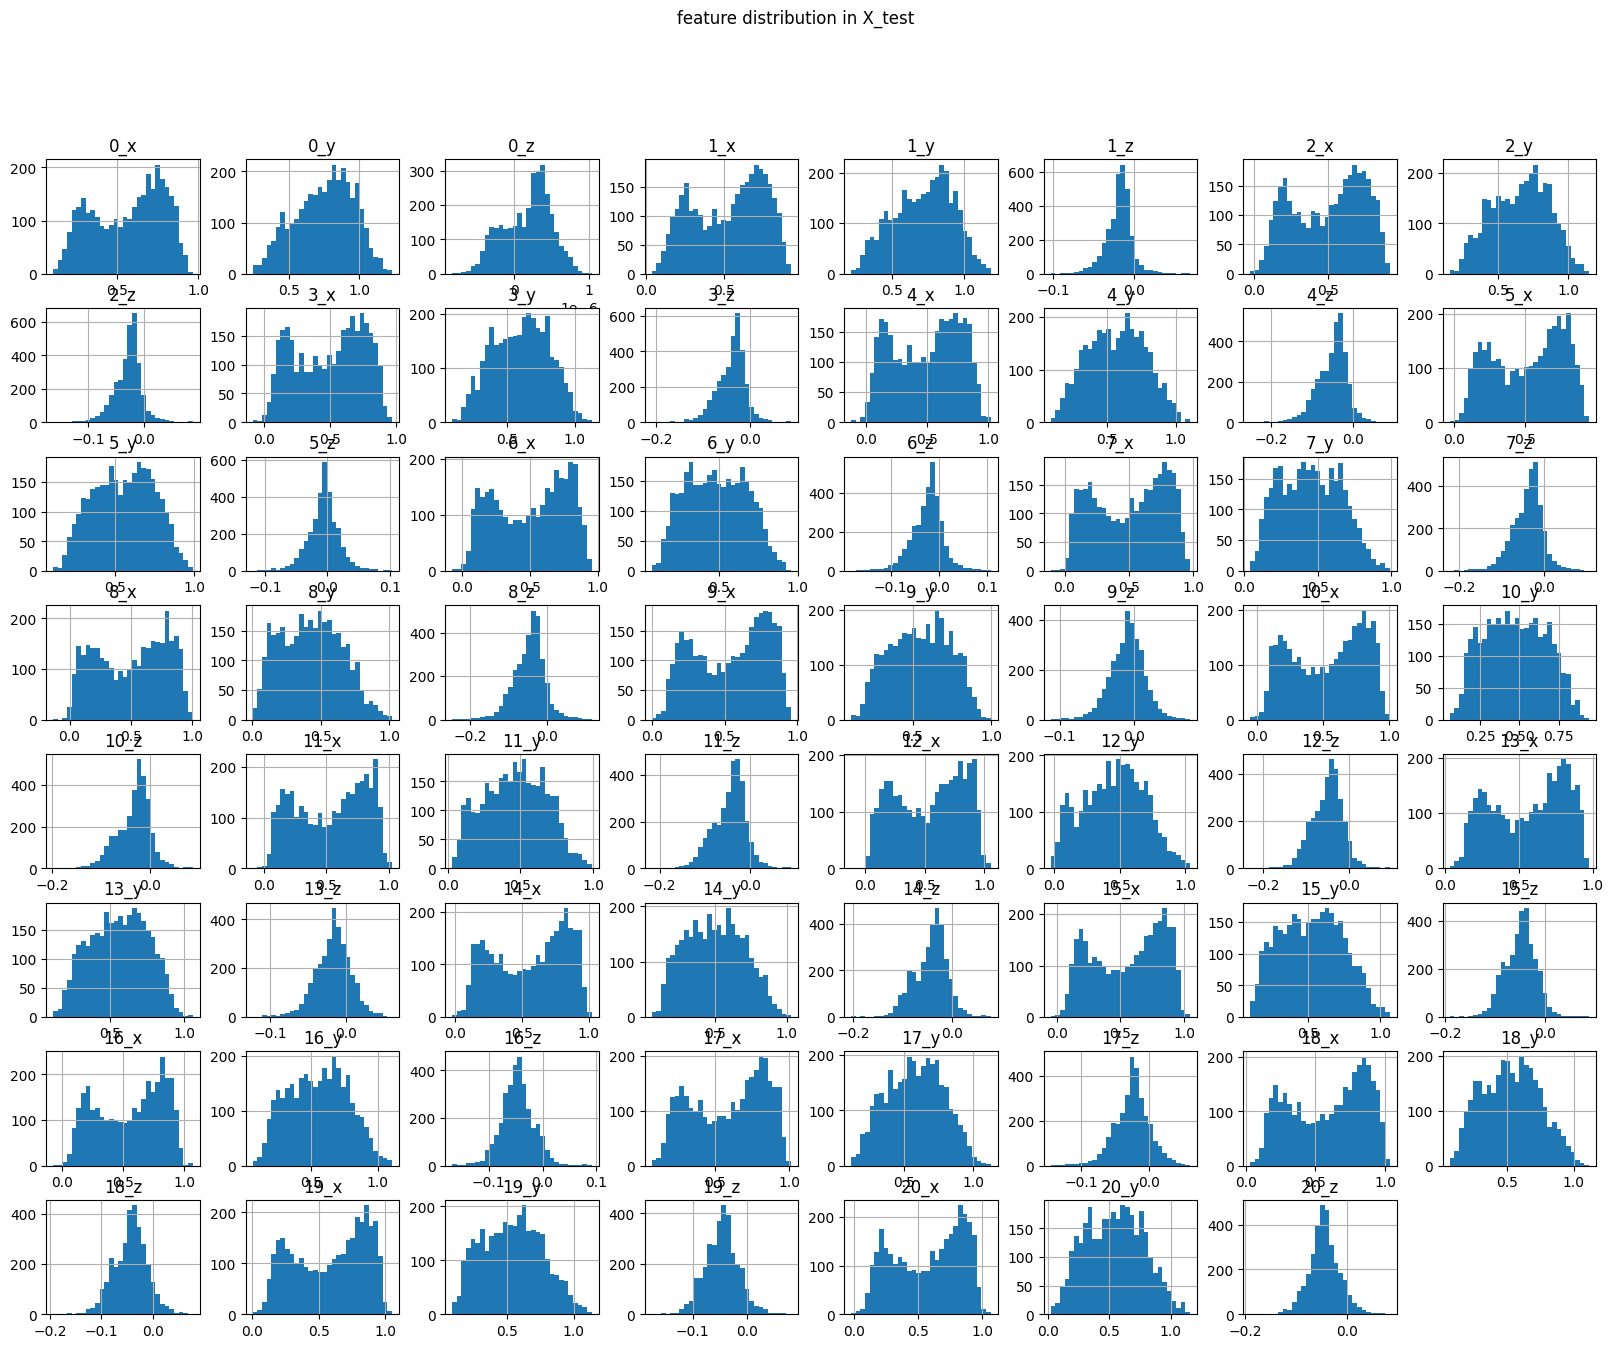

In [8]:
# distribution features in training 
X_train.hist(figsize=(20, 15), bins=30)
plt.suptitle("feature distribution in X_test")
plt.show()

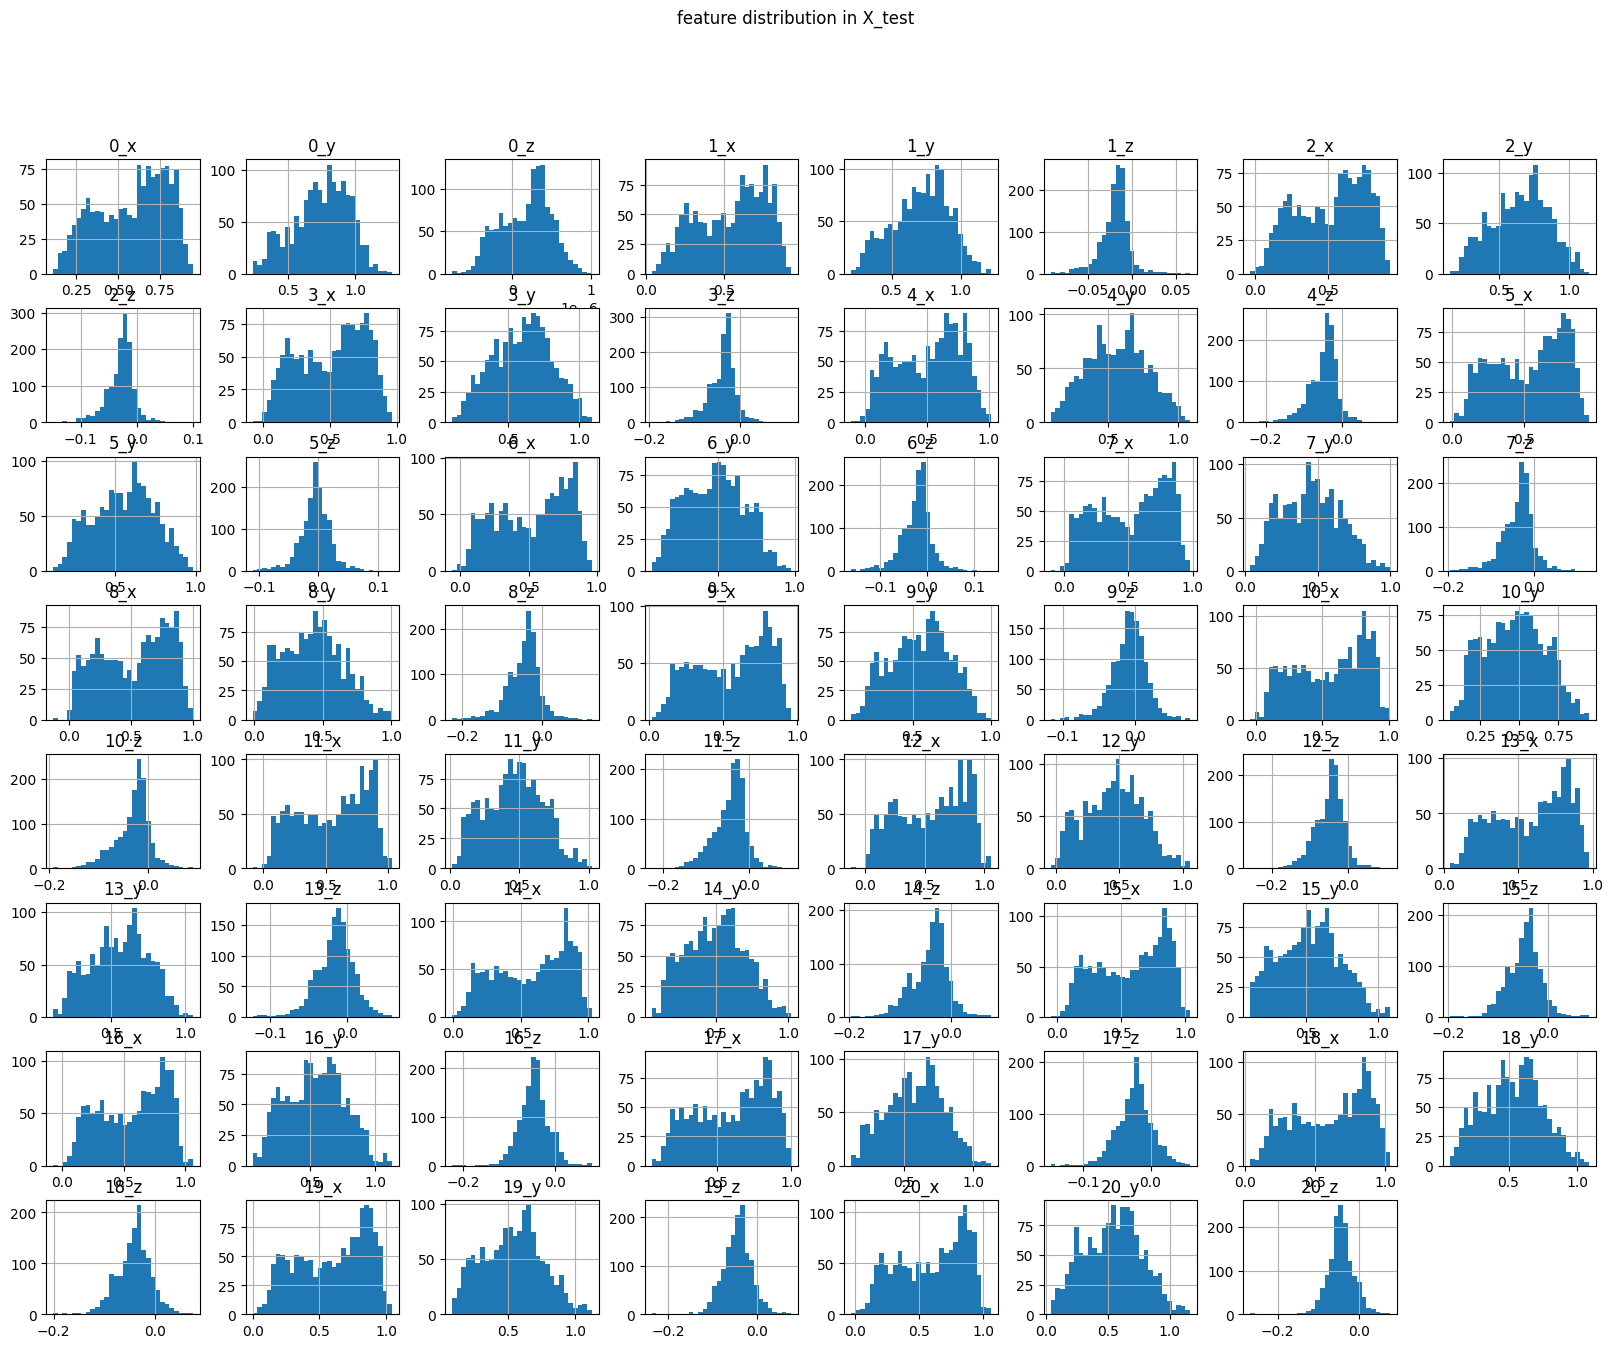

In [9]:
# distribution features in testing
X_test.hist(figsize=(20, 15), bins=30)
plt.suptitle("feature distribution in X_test")
plt.show()

In [16]:
# # visualizing feature importance
# importances = model.feature_importances_
# feature_names = X_test.columns

# # Plot feature importance
# plt.figure(figsize=(12, 6))
# sns.barplot(x=importances, y=feature_names)
# plt.title("Feature Importances")
# plt.show()

In [17]:
# load StandardScaler from pickle
scaler_path = 'checkpoints/pickles/scaler/scaler_pickle_1.pkl'
with open(scaler_path, "rb") as f:
        scaler = pickle.load(f)

X_test_norm = scaler.transform(X_test)

In [18]:
# creating tensor
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [19]:
# creating dataloader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


In [20]:
# creating batch loader
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [21]:
# perform predictions on the test data
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # forward pass
        predictions = model(X_batch)
        
        # output predictions
        _, pred_labels = torch.max(predictions, 1)
        
        all_preds.extend(pred_labels.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

In [22]:
# evaluating the model
# 1. classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       430
         1.0       0.89      0.94      0.91       136
         2.0       0.98      0.91      0.94       149
         3.0       0.93      0.93      0.93       165
         4.0       0.88      0.91      0.89       144
         5.0       0.97      0.90      0.93       186
         6.0       0.90      0.97      0.93       177

    accuracy                           0.94      1387
   macro avg       0.93      0.93      0.93      1387
weighted avg       0.94      0.94      0.94      1387



In [23]:
# 2. confusion matrix
print("confusion matrix:")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

confusion matrix:
[[422   5   2   0   1   0   0]
 [  0 128   1   0   6   1   0]
 [  0  11 136   0   1   0   1]
 [  2   0   0 153  10   0   0]
 [  1   0   0  11 131   0   1]
 [  1   0   0   0   0 167  18]
 [  1   0   0   0   0   5 171]]


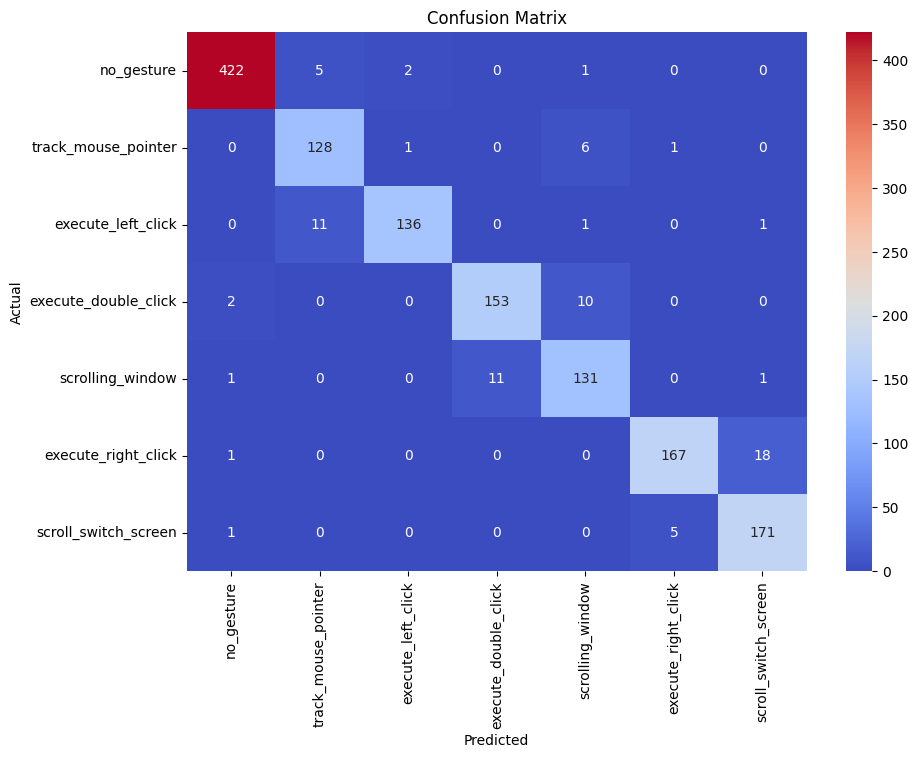

In [26]:
# visualization
gesture_labels ={
    0: "no_gesture",                    # nothing_detected
    1: "track_mouse_pointer",           # index_finger_up
    2: "execute_left_click",            # index_and_thumb_up
    3: "execute_double_click",          # index_and_middle_spaced
    4: "scrolling_window",              # index_and_middle_together
    5: "execute_right_click",           # index_thumb_middle_spaced
    6: "scroll_switch_screen"           # index_thumb_middle_together  NOT SUPPORTED IN MAC
}

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=gesture_labels.values(), yticklabels=gesture_labels.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [29]:
# measuring time inference
import time


# sample = torch.tensor(X_test[0], dtype=torch.float32)  # single test sample
sample = X_test_tensor[0].unsqueeze(0)
num_iterations = 100

start_time = time.time()
for _ in range(num_iterations):
    _ = model(sample.to(device))
    
end_time = time.time()

average_time = (end_time - start_time) / num_iterations
print(f"Average inference time per sample: {average_time:.6f} seconds")

Average inference time per sample: 0.000608 seconds


In [32]:
from sklearn.metrics import accuracy_score

class PyTorchModelWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device
    
    def fit(self, X, y):
        # No fitting needed as the model is already trained
        pass
    
    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, preds = torch.max(outputs, 1)
        return preds.cpu().numpy()
    
    def score(self, X, y):
        preds = self.predict(X)
        return accuracy_score(y, preds)


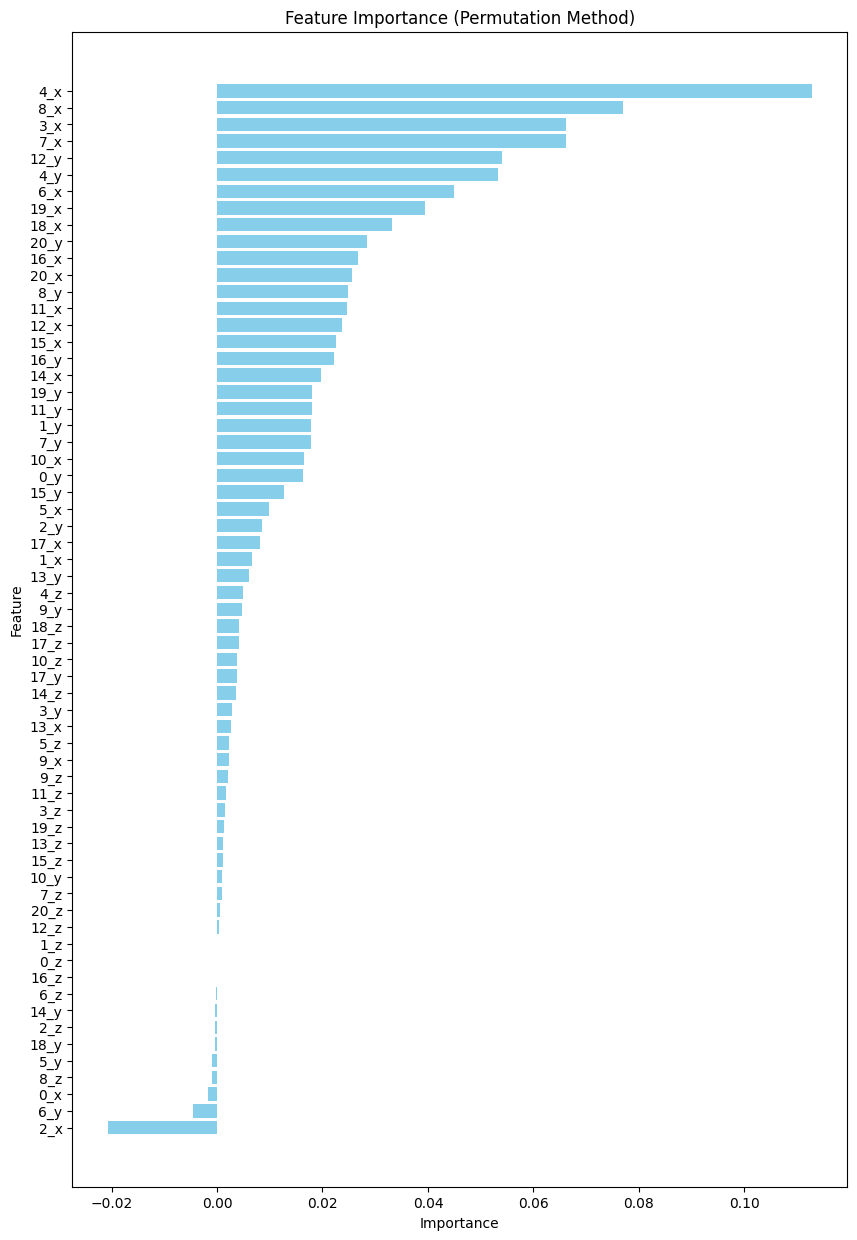

In [ ]:
from sklearn.inspection import permutation_importance

# Wrap the trained PyTorch model
model_wrapper = PyTorchModelWrapper(model, device)

# Compute permutation importance
perm_importance = permutation_importance(
    model_wrapper, 
    X_test.values,  # Pass as numpy array
    y_test.values,  # Pass as numpy array
    n_repeats=10, 
    random_state=42
)

# Create a DataFrame for feature importance
feature_names = X_test.columns
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_importance.importances_mean
})
importance_df.sort_values(by="Importance", ascending=False, inplace=True)

# Plot feature importance
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.title("Feature Importance (Permutation Method)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()
